# Import Libraries

In [1]:
import json
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import timeit
from nltk.stem import WordNetLemmatizer 
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px

# Read Data

In [2]:
f = open('dataset.json')
data = json.load(f)

In [3]:
df=pd.DataFrame(data)
f.close()
df

,externalStatus,internalStatus
0,PORT OUT,Port Out
1,TERMINAL IN,Inbound Terminal
2,PORT IN,Port In
3,Vessel departure from first POL (Vessel name :...,Departure
4,Vessel arrival at final POD (Vessel name : TIA...,Arrival
...,...,...
1217,Import Loaded on Rail,Loaded on Vessel
1218,Full Transshipment Loaded,Loaded on Vessel
1219,Full Transshipment Loaded,Loaded on Vessel
1220,Export Loaded on Vessel,Loaded on Vessel


In [4]:
df.internalStatus.value_counts()

Loaded on Vessel            331
Departure                   287
Gate Out                    146
Gate In                     143
Arrival                      62
Empty Return                 47
Empty Container Released     47
Unloaded on Vessel           37
On Rail                      25
Off Rail                     25
Outbound Terminal            24
Port Out                     15
Port In                      14
In-transit                   10
Inbound Terminal              9
Name: internalStatus, dtype: int64

# Basic data information

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222 entries, 0 to 1221
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   externalStatus  1222 non-null   object
 1   internalStatus  1222 non-null   object
dtypes: object(2)
memory usage: 19.2+ KB


In [6]:
df.isnull().sum()

externalStatus    0
internalStatus    0
dtype: int64

# EDA

In [7]:
def feature_frequency(df,feature):
    company_counts = df[feature].value_counts()
    plt.figure(figsize=(8, 4))
    company_counts.plot(kind='barh', color='skyblue')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Frequency of Each {feature}')
    plt.show()

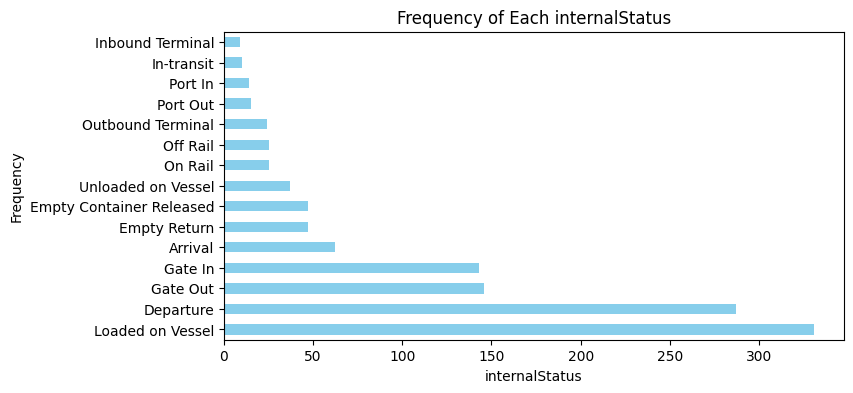

In [8]:
feature_frequency(df,'internalStatus')

In [9]:
def plot_top_n_words(data,feature,n):
    text_data = [i for i in data[feature].values]
    all_text = ' '.join(text_data)
    words = all_text.split()
    word_freq = pd.Series(words).value_counts()
    top_n_words = word_freq.head(n)
    top_n_df = top_n_words.reset_index()
    top_n_df.columns = ['Word', 'Frequency']
    plt.figure(figsize=(14, 6))
    sns.barplot(x='Word', y='Frequency', data=top_n_df, palette='viridis')

    plt.xticks(rotation=45)
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.title(f'Top {n} Words for {feature}')
    plt.show()

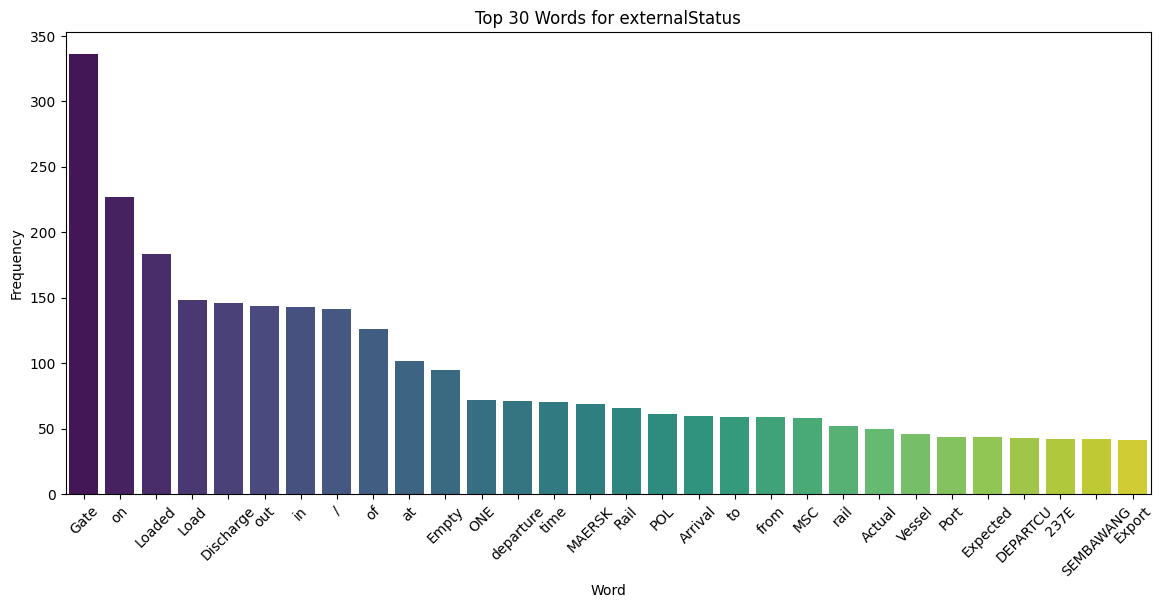

In [10]:
plot_top_n_words(df,'externalStatus',30)

In [11]:
# Let's do data cleaning first and then check top words for the corresponding internal status through wordcloud

# Data Cleaning

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rajpo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
lemma = WordNetLemmatizer() # applying lemmatization to return dictionary form of words

all_stopwords = stopwords.words('english') # this consists all the stopwords, which will be removed later.

# Removing the following words from list containing stopwords
all_stopwords.remove('in')
all_stopwords.remove('out')
all_stopwords.remove('on')
all_stopwords.remove('of')
all_stopwords.remove('off')

def clean_text(text):
    """
    This function removes punctuations, stopwords and other non alpha numeric characters.
    We expand the contractions and replace some words by an empty string
    
    """
    statement = text.lower().strip()
    statement = re.sub('[^a-zA-Z]',' ',statement) # replacing whatever isn't letters by an empty string
    statement = statement.split() # forming list of words in a given review
    final_statement = [lemma.lemmatize(word) for word in statement if not word in set(all_stopwords) and len(word)>1]
    final_statement_ = ' '.join(final_statement) # joining the words and forming the review again without stopwords
    return final_statement_  

In [14]:
df['clean_external_status'] = df['externalStatus'].apply(lambda x : clean_text(x))

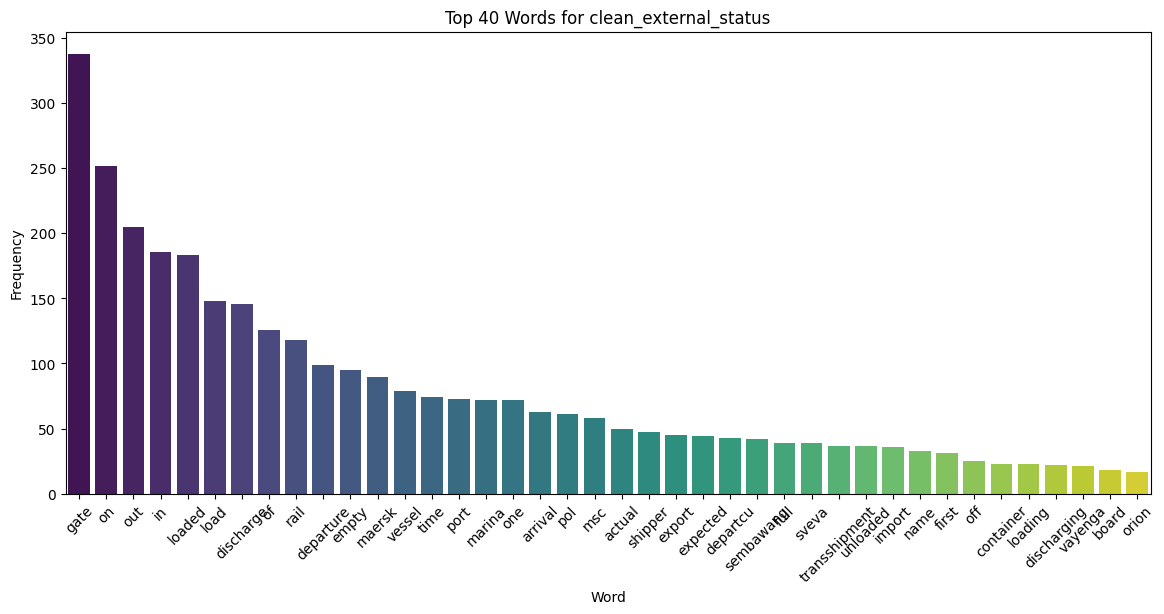

In [15]:
plot_top_n_words(df,'clean_external_status',40)

# Wordcloud based on internalStatus

In [16]:
def wc(data,feature):
    s1 = data.groupby(by = 'internalStatus')
    s2 = s1.get_group(feature)
    all_words = s2["clean_external_status"].values
    #print(all_words)
    
    wordcloud = WordCloud(background_color = 'black', width = 512,height = 384,contour_color='black',contour_width=1,
                         colormap='RdYlGn',collocations=True).generate(' '.join(list(set(all_words))))
    plt.title(f"Wordcloud for {feature}")
    plt.imshow(wordcloud) # image show
    plt.axis('off') # to off the axis of x and y

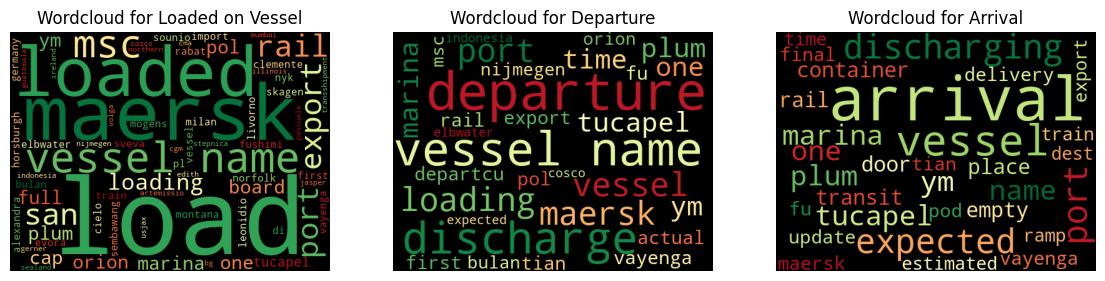

In [17]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
wc(df,'Loaded on Vessel')

plt.subplot(1, 3, 2)
wc(df,'Departure')

plt.subplot(1, 3, 3)
wc(df,'Arrival')

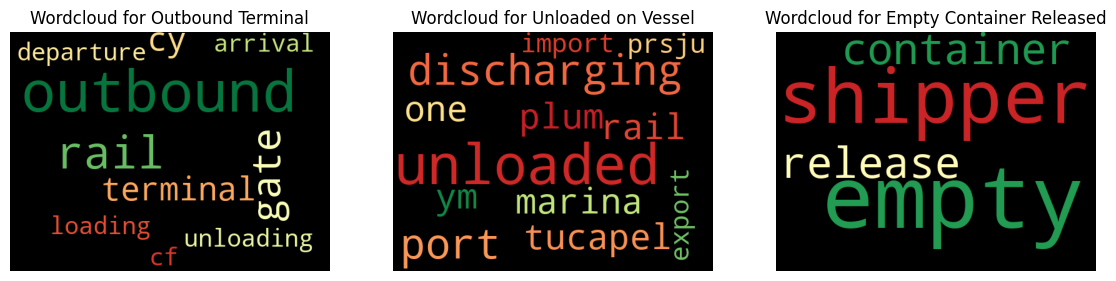

In [18]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
wc(df,'Outbound Terminal')

plt.subplot(1, 3, 2)
wc(df,'Unloaded on Vessel')

plt.subplot(1, 3, 3)
wc(df,'Empty Container Released')

# Splitting the dataset

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
df.columns

Index(['externalStatus', 'internalStatus', 'clean_external_status'], dtype='object')

In [21]:
x = df.drop(['internalStatus'],axis = 1)
y = df['internalStatus']

In [22]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.15,stratify = y,random_state = 0)

In [23]:
x_train.shape,y_train.shape

((1038, 2), (1038,))

In [24]:
x_test.shape,y_test.shape

((184, 2), (184,))

# Data Preprocessing

In [25]:
# Encodng  the target variables
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(x_train.clean_external_status.values)
X_test_tfidf = tfidf_vectorizer.transform(x_test.clean_external_status.values)

In [27]:
X_train_tfidf.shape,X_test_tfidf.shape

((1038, 99), (184, 99))

In [28]:
feature_names = tfidf_vectorizer.get_feature_names_out()
print("\nFeature Names:")
print(feature_names)


Feature Names:
['actual' 'alexandra' 'arrival' 'artemissio' 'board' 'bulan' 'cap' 'cf'
 'cgm' 'cielo' 'clemente' 'cma' 'container' 'cosco' 'crossed' 'customer'
 'cy' 'delivery' 'departcu' 'departure' 'dest' 'di' 'discharge'
 'discharging' 'door' 'edith' 'elbwater' 'empty' 'estimated' 'evora'
 'expected' 'export' 'first' 'full' 'gate' 'gerner' 'guatemala'
 'horsburgh' 'illinois' 'import' 'in' 'indonesia' 'jasper' 'leonidio'
 'load' 'loaded' 'loading' 'maersk' 'marina' 'milan' 'mogens' 'montana'
 'msc' 'mumbai' 'name' 'nijmegen' 'norfolk' 'northern' 'of' 'off' 'on'
 'one' 'orion' 'out' 'outbound' 'pascuale' 'place' 'plaza' 'plum' 'pol'
 'port' 'prsju' 'rabat' 'rail' 'ramp' 'release' 'returned' 'san' 'sealand'
 'sembawang' 'shipper' 'skagen' 'sounio' 'stepnica' 'sveva' 'terminal'
 'time' 'toll' 'train' 'transit' 'transshipment' 'tucapel' 'unloaded'
 'update' 'usjax' 'vayenga' 'vessel' 'volga' 'ym']


# Model Building

In [29]:
# Use class weights for tree based models
from sklearn.utils import class_weight

classes = np.unique(y_train_encoded)
cw = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train_encoded), y = y_train_encoded)
weights = dict(zip(classes,cw))

In [30]:
weights

{0: 1.3056603773584905,
 1: 0.2836065573770492,
 2: 1.73,
 3: 1.73,
 4: 0.571900826446281,
 5: 0.5580645161290323,
 6: 7.688888888888889,
 7: 8.65,
 8: 0.24626334519572954,
 9: 3.295238095238095,
 10: 3.295238095238095,
 11: 3.46,
 12: 5.766666666666667,
 13: 5.323076923076923,
 14: 2.232258064516129}

# Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [32]:
rf_classifier = RandomForestClassifier(class_weight=weights,random_state=42)
rf_classifier.fit(X_train_tfidf, y_train_encoded)

RandomForestClassifier(class_weight={0: 1.3056603773584905,
                                     1: 0.2836065573770492, 2: 1.73, 3: 1.73,
                                     4: 0.571900826446281,
                                     5: 0.5580645161290323,
                                     6: 7.688888888888889, 7: 8.65,
                                     8: 0.24626334519572954,
                                     9: 3.295238095238095,
                                     10: 3.295238095238095, 11: 3.46,
                                     12: 5.766666666666667,
                                     13: 5.323076923076923,
                                     14: 2.232258064516129},
                       random_state=42)

In [33]:
predict_test = rf_classifier.predict(X_test_tfidf)
predict_train = rf_classifier.predict(X_train_tfidf)

In [34]:
f1_train = f1_score(y_train_encoded, predict_train, average='weighted')
print("Train F1 Score:", f1_train)

f1_test = f1_score(y_test_encoded, predict_test, average='weighted')
print("Test F1 Score:", f1_test)

Train F1 Score: 1.0
Test F1 Score: 1.0


In [35]:
y_pred_original = label_encoder.inverse_transform(predict_test)
predictions_df= pd.DataFrame({"external_status":x_test.externalStatus.values,"internalStatus":y_test,"Encoded Predictions":predict_test,"Actual Prediction" : y_pred_original})
predictions_df

,external_status,internalStatus,Encoded Predictions,Actual Prediction
723,Gate in,Gate In,4,Gate In
320,Unloaded PRSJU,Unloaded on Vessel,14,Unloaded on Vessel
231,"Gate out, Empty",Empty Return,3,Empty Return
38,Load on MSC ORION / 227N,Loaded on Vessel,8,Loaded on Vessel
1027,Empty to Shipper,Empty Container Released,2,Empty Container Released
...,...,...,...,...
975,'MARINA ONE 001S' Departure from Port of Loadi...,Departure,1,Departure
1055,Gate in,Gate In,4,Gate In
645,Gate out,Gate Out,5,Gate Out
385,Loaded at T/S POL,Loaded on Vessel,8,Loaded on Vessel


# LGBM:

In [36]:
import lightgbm as ltb

In [37]:
lgbm = ltb.LGBMClassifier()
lgbm.fit(X_train_tfidf.toarray(),y_train_encoded)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 1038, number of used features: 36
[LightGBM] [Info] Start training from score -2.974759
[LightGBM] [Info] Start training from score -1.447883
[LightGBM] [Info] Start training from score -3.256172
[LightGBM] [Info] Start training from score -3.256172
[LightGBM] [Info] Start training from score -2.149261
[LightGBM] [Info] Start training from score -2.124769
[LightGBM] [Info] Start training from score -4.747826
[LightGBM] [Info] Start training from score -4.865610
[LightGBM] [Info] Start training from score -1.306696
[LightGBM] [Info] Start training from score -3.900529
[LightGBM] [Info] Start training from score -3.900529
[LightGBM] [Info] Start training from score -3.949319
[

LGBMClassifier()

In [38]:
lgbm_predict_test = lgbm.predict(X_test_tfidf.toarray())
lgbm_predict_train = lgbm.predict(X_train_tfidf.toarray())

In [39]:
f1_train = f1_score(y_train_encoded, lgbm_predict_train, average='weighted')
print("Train F1 Score:", f1_train)

f1_test = f1_score(y_test_encoded, lgbm_predict_test, average='weighted')
print("Test F1 Score:", f1_test)

Train F1 Score: 1.0
Test F1 Score: 0.9814311594202899


# Using Tensorflow for modeling:

In [40]:
import tensorflow as tf

In [41]:
def tf_model(input_dim,num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

num_classes = len(np.unique(y_train_encoded))
model = tf_model(X_train_tfidf.shape[1],num_classes)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6400      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 15)                495       
                                                                 
Total params: 8975 (35.06 KB)
Trainable params: 8975 (35.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
# Convert integer-encoded labels to one-hot encoded format
y_train_onehot = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test_encoded, num_classes)

In [44]:
X_train_tfidf.toarray().shape, y_train_onehot.shape

((1038, 99), (1038, 15))

In [45]:
# Train the model
model.fit(X_train_tfidf.toarray(), y_train_onehot, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100
30/30 [==============================] - 1s 9ms/step - loss: 2.6386 - accuracy: 0.2195 - val_loss: 2.5307 - val_accuracy: 0.5481
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 2.3734 - accuracy: 0.5139 - val_loss: 2.1776 - val_accuracy: 0.5865
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 1.9168 - accuracy: 0.5353 - val_loss: 1.6630 - val_accuracy: 0.5865
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4615 - accuracy: 0.6306 - val_loss: 1.2398 - val_accuracy: 0.7308
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 1.1433 - accuracy: 0.7227 - val_loss: 0.9617 - val_accuracy: 0.7308
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9170 - accuracy: 0.7484 - val_loss: 0.7792 - val_accuracy: 0.7692
Epoch 7/100
30/30 [==============================] - 0s 5ms/step - loss: 0.7606 - accuracy: 0.7923 - val_loss: 0.6324 - val_accuracy: 0.8077
Epoch 8/100
3

In [46]:
model.evaluate(X_test_tfidf,y_test_onehot)

6/6 [==============================] - 0s 3ms/step - loss: 0.0027 - accuracy: 1.0000


[0.0027241799980401993, 1.0]

In [47]:
# Make predictions on the test set
y_pred_prob = model.predict(X_test_tfidf)
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute the F1 score using one-hot encoded test labels
f1 = f1_score(y_test_onehot.argmax(axis=1), y_pred, average='weighted')
print("F1 Score:", f1)


6/6 [==============================] - 0s 3ms/step
F1 Score: 1.0


# As we see, Random forest and Keras model gave us the best accuray (f1 score), so we will be using one of those to develop the API

In [48]:
y_pred_original = label_encoder.inverse_transform(y_pred)

In [49]:
predictions_df= pd.DataFrame({"external_status":x_test.externalStatus.values,"internalStatus":y_test,"Predictions":y_pred_original})

In [50]:
predictions_df

,external_status,internalStatus,Predictions
723,Gate in,Gate In,Gate In
320,Unloaded PRSJU,Unloaded on Vessel,Unloaded on Vessel
231,"Gate out, Empty",Empty Return,Empty Return
38,Load on MSC ORION / 227N,Loaded on Vessel,Loaded on Vessel
1027,Empty to Shipper,Empty Container Released,Empty Container Released
...,...,...,...
975,'MARINA ONE 001S' Departure from Port of Loadi...,Departure,Departure
1055,Gate in,Gate In,Gate In
645,Gate out,Gate Out,Gate Out
385,Loaded at T/S POL,Loaded on Vessel,Loaded on Vessel


# Testing our function for desired output

In [51]:
def predict_internal_status(text, model, tfidf_vectorizer, label_encoder):
    cleaned_text = clean_text(text)   # Preprocess the input text
    if not cleaned_text: # Check if text is empty
        return "Error: Empty input text"
    try:
        tfidf_features = tfidf_vectorizer.transform([cleaned_text])  # Transform the preprocessed text using TF-IDF vectorizer
        pred = model.predict(tfidf_features) # Predict the internal status using the model
        y_pred = np.argmax(pred, axis=1)  # Convert predicted labels to original class labels
        y_pred_original = label_encoder.inverse_transform(y_pred)
        return y_pred_original[0]
        
    except Exception as e:
        return f"Error: {str(e)}"


In [52]:
predict_internal_status("Unloaded IOIHD",model,tfidf_vectorizer, label_encoder)

1/1 [==============================] - 0s 27ms/step


'Unloaded on Vessel'

# Saving the model and required files

In [53]:
import pickle

In [54]:
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [55]:
model.save('model.h5')
print('Model Saved!')

Model Saved!
